In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import os
import re
from fuzzywuzzy import process
import warnings
warnings.filterwarnings('ignore')

In [133]:
%load_ext autoreload
%autoreload 2
from funciones.funciones import check_df
from funciones.funciones import identificacion_valores_problem

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Análisis de los datos de campañas de marketing de una empresa Fintech para
conseguir identificar patrones, tendencias y factores que influyen en que un
cliente acabe contratando un depósito. Tras un análisis exhaustivo de todos sus
datos, habrá que implementar un modelo simple que ayude a entender y predecir
la efectividad de las campañas de marketing, y diseñar un dashboard para la
capa ejecutiva de la fintech con los principales insights y KPIs de los resultados
de las campañas.

In [134]:
os.getcwd()

'c:\\Users\\Arnau\\OneDrive\\Documentos\\GitHub\\data-analytics-tfm'

In [135]:
df = pd.read_excel('bank-additional_bank-additional-full.xlsx')

# **1. Análisis de datos: Índice (PDF)**


- Entendimiento de datos de clientes, de los detalles de las
campañas y sus resultados
- Estadísticas descriptivas para entender las características básicas
de los datos.
- Análisis de la relación entre características demográficas del
cliente (edad, trabajo, educación) y la suscripción a un depósito a
plazo.
- Evaluación del impacto de los detalles de la campaña (número de
contactos, mes, día de la semana) en el resultado de la campaña.

Cada punto de ahora en adelante es un punto del guión del trabajo

## **1.1. Entendimiento de datos de clientes**

### **Datos del cliente**

* **age:** Edad

* **job:** Profesión (admin, blue-collar, technician, etc.)

* **marital:** Estado civil (married, single, divorced)

* **education:** Nivel de estudios

* **default:** ¿Ha tenido impagos de crédito? (yes/no/unknown)

* **housing:** ¿Tiene hipoteca? (yes/no/unknown)

* **loan:** ¿Tiene préstamo personal? (yes/no/unknown)


### **Datos de la campaña actual**

* **contact:** Tipo de contacto (cellular/telephone)

* **month:** Mes del último contacto

* **day_of_week:** Día de la semana del último contacto

* **duration:** Duración de la llamada en segundos

* **campaign:** Número de contactos realizados en esta campaña para este cliente


### **Datos de campañas anteriores**

* **pdays:** Días desde el último contacto de una campaña anterior (999 = nunca contactado antes)

* **previous:** Número de contactos en campañas anteriores

* **poutcome:** Resultado de la campaña anterior (success/failure/nonexistent)


### **Datos de indicadores macroeconómicos**

* **emp.var.rate (Employment Variation Rate):**  Tasa de variación del empleo. Mide el cambio porcentual en el nivel de empleo respecto al trimestre anterior. Un valor negativo indica destrucción de empleo, positivo indica creación.

* **cons.price.idx (Consumer Price Index):**   Índice de precios al consumo. Básicamente, la inflación. Valores más altos = cosas más caras.

* **cons.conf.idx(Consumer Confidence Index):** Índice de confianza del consumidor. Mide el optimismo/pesimismo de los hogares sobre la economía.

* **euribor3m:**  El Euríbor a 3 meses. El tipo de interés al que los bancos europeos se prestan dinero entre sí. Afecta directamente a hipotecas y productos financieros.

* **nr.employed:** Número de empleados (en miles, normalmente). El volumen total de personas empleadas en el país en ese momento.


### **Contratación o no**

* **y**: Sí ha contratado o no el depósito.

___________________________

## 1.2 **Estadísticas descriptivas**

In [136]:
check_df(df)

¿Cuántas filas y columnas hay en el conjunto de datos?
	Hay 41,188 filas y 21 columnas.

########################################################################################
¿Cuáles son las primeras cinco filas del conjunto de datos?


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4857,5191,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4857,5191,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4857,5191,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4857,5191,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4857,5191,no



########################################################################################
¿Cuáles son las últimas cinco filas del conjunto de datos?


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94767.0,-50.8,1028,4963-06-01 00:00:00,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94767.0,-50.8,1028,4963-06-01 00:00:00,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94767.0,-50.8,1028,4963-06-01 00:00:00,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94767.0,-50.8,1028,4963-06-01 00:00:00,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94767.0,-50.8,1028,4963-06-01 00:00:00,no



########################################################################################
¿Cómo puedes obtener una muestra aleatoria de filas del conjunto de datos?


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
32676,30,admin.,single,university.degree,no,yes,no,cellular,may,mon,...,1,999,0,nonexistent,-1.8,92893.0,-46.2,1299,5099-01-01 00:00:00,no
31038,40,admin.,married,professional.course,no,unknown,unknown,cellular,may,tue,...,1,999,0,nonexistent,-1.8,92893.0,-46.2,1344,5099-01-01 00:00:00,no
24279,42,technician,married,professional.course,unknown,yes,no,cellular,nov,mon,...,1,4,1,success,-0.1,93.2,-42.0,4191,5195-08-01 00:00:00,no
39595,29,admin.,single,university.degree,no,yes,no,cellular,may,wed,...,1,999,1,failure,-1.8,93876.0,-40.0,672,5008-07-01 00:00:00,yes
28626,51,entrepreneur,married,illiterate,no,no,no,cellular,apr,thu,...,2,999,0,nonexistent,-1.8,93075.0,-47.1,1.41,5099-01-01 00:00:00,no



########################################################################################
¿Cuáles son las columnas del conjunto de datos? ¿Cuál es el tipo de datos de cada columna?
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate       object
cons.price.idx    float64
cons.conf.idx     float64
euribor3m          object
nr.employed        object
y                  object
dtype: object

########################################################################################
¿Cuántas columnas hay de cada tipo de datos?
object     14
int64       5
float64     2
Name: count, dtype: int64

#######################################################

,age,duration,campaign,pdays,previous,cons.price.idx,cons.conf.idx
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,85401.579955,-40.502600
std,10.42125,259.279249,2.770014,186.910907,0.494901,26471.506796,4.628198
min,17.00000,0.000000,1.000000,0.000000,0.000000,93.200000,-50.800000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,92893.000000,-42.700000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,93749.000000,-41.800000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,93994.000000,-36.400000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,94767.000000,-26.900000



########################################################################################
¿Cuáles son las estadísticas descriptivas básicas de las columnas categóricas?


,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,emp.var.rate,euribor3m,nr.employed,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,10,315,11,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,2026-04-01 00:00:00,4857,5228-01-01 00:00:00,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,16234,2868,16234,36548


**¿Qué valores tienen las columnas categóricas?**

In [137]:
for campo_categorico in df:
    if df[campo_categorico].dtype == 'object':
        print(campo_categorico)
        print(df[campo_categorico].unique())
        print('______')

job
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
______
marital
['married' 'single' 'divorced' 'unknown']
______
education
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
______
default
['no' 'unknown' 'yes']
______
housing
['no' 'yes' 'unknown']
______
loan
['no' 'yes' 'unknown']
______
contact
['telephone' 'cellular']
______
month
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
______
day_of_week
['mon' 'tue' 'wed' 'thu' 'fri']
______
poutcome
['nonexistent' 'failure' 'success']
______
emp.var.rate
[datetime.datetime(2026, 1, 1, 0, 0) datetime.datetime(2026, 4, 1, 0, 0)
 '-0.1' '-0.2' '-1.8' '-2.9' '-3.4' -3 '-1.7' '-1.1']
______
euribor3m
[4857 4856 4855 4859 '4.86' 4858 4864 4865 4866 4967 4961 4959 4958 '4.96'
 4962 4955 4947 4956 4966 4963 4957 4968 '4.97' 4965 4964 5045 5 4936 4921
 4918 4912 482

**¿Qué valores tienen las columnas numéricas?**

In [138]:
for campo_numerico in df:
    if df[campo_numerico].dtype in ['int64', 'float64']:
        print(campo_numerico)
        print(df[campo_numerico].unique())
        print('______')

age
[56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]
______
duration
[ 261  149  226 ... 1246 1556 1868]
______
campaign
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 19 18 23 14 22 25 16 17 15 20 56
 39 35 42 28 26 27 32 21 24 29 31 30 41 37 40 33 34 43]
______
pdays
[999   6   4   3   5   1   0  10   7   8   9  11   2  12  13  14  15  16
  21  17  18  22  25  26  19  27  20]
______
previous
[0 1 2 3 4 5 6 7]
______
cons.price.idx
[9.3994e+04 9.4465e+04 9.3918e+04 9.3444e+04 9.3798e+04 9.3200e+01
 9.2756e+04 9.2843e+04 9.3075e+04 9.2893e+04 9.2963e+04 9.2469e+04
 9.2201e+04 9.2379e+04 9.2431e+04 9.2649e+04 9.2713e+04 9.3369e+04
 9.3749e+04 9.3876e+04 9.4055e+04 9.4215e+04 9.4027e+04 9.4199e+04
 9.4601e+04 9.4767e+04]
______
cons.conf.idx
[-36.4 -41.8 -42.7 -36.1 -40.4 -42.  -45.9 -50.  -47.1 -46.2 -40.8 

________________________________

## **1.3. Limpieza de datos**

Vemos que hay bastantes campos que renombrar, tipos de datos que hay que cambiar y datos erróneos. Analizamos primero qué tendríamos que revisar a primera vista.

### **1.3.1. Campos a limpiar**


- **Ordenar**
    - ~~Month~~
    - Day
    - Education
- **Reformatear**
    - Valores
        - Duration
            Pasar a minutos
         Education --> -->
            - ¿Cambiamos los valores?
        - Día
            - Nombre completo y en primera mayuscula
        - Job
        - emp.var.rate
            - Hay mezcla de fechas, ints y floats
            - Debería ser float

      ~~- nr.employed~~
            ~~- Está en formato fecha~~
            ~~-Tendría que ser int~~
            


**Preguntas al profe**

- El 95% de los clientes no tuvieron contacto previo, y tienen el valor 999. ¿Qué hacemos con él?

_____________________________________________________________________________________________________________

### **1.3.2. Valores problemáticos**

#### **1.3.2.1. Nulos y Outliers**

In [139]:
identificacion_valores_problem(df)

###################################################################################
3.1.1. Proporción de NULOS en cada una de las columnas del conjunto de datos:
age               0.0
campaign          0.0
nr.employed       0.0
euribor3m         0.0
cons.conf.idx     0.0
cons.price.idx    0.0
emp.var.rate      0.0
poutcome          0.0
previous          0.0
pdays             0.0
duration          0.0
job               0.0
day_of_week       0.0
month             0.0
contact           0.0
loan              0.0
housing           0.0
default           0.0
education         0.0
marital           0.0
y                 0.0
dtype: float64
###################################################################################
3.1.2. Número de DUPLICADOS totales: 12
###################################################################################
3.1.3. Columnas numéricas con OUTLIERS
Número de outliers en la columna "age": 469
Número de outliers en la columna "duration": 2963
Número de outliers e

#### **1.3.2.2. Duplicados**

¿Cuántos duplicados hay?

In [140]:
df.duplicated().sum()

np.int64(12)

¿Dónde están los duplicados?

In [141]:
df[df.duplicated(keep=False)]

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
1265,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4855,5191,no
1266,39,blue-collar,married,basic.6y,no,no,no,telephone,may,thu,...,1,999,0,nonexistent,2026-01-01 00:00:00,93994.0,-36.4,4855,5191,no
12260,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4966,5228-01-01 00:00:00,no
12261,36,retired,married,unknown,no,no,no,telephone,jul,thu,...,1,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4966,5228-01-01 00:00:00,no
14155,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4962,5228-01-01 00:00:00,no
14234,27,technician,single,professional.course,no,no,no,cellular,jul,mon,...,2,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4962,5228-01-01 00:00:00,no
16819,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4962,5228-01-01 00:00:00,no
16956,47,technician,divorced,high.school,no,yes,no,cellular,jul,thu,...,3,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4962,5228-01-01 00:00:00,no
18464,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4968,5228-01-01 00:00:00,no
18465,32,technician,single,professional.course,no,yes,no,cellular,jul,thu,...,1,999,0,nonexistent,2026-04-01 00:00:00,93918.0,-42.7,4968,5228-01-01 00:00:00,no


### **1.3.3. Limpieza**

#### **1.3.3.1. Renombrar campos**

Renombramos columnas y llamamos al df "df_clean"

In [142]:
df_clean = df.copy()
df_clean = df_clean.rename(columns={'y':'result',
                                    'pdays':'days_last_contact',
                                    'emp.var.rate':'employment_variation_rate',
                                    'previous':'number_previous_contacts',
                                    'nr.employed':'nr_employed',
                                    'housing':'mortgage',
                                    'default':'credit_default',
                                    'campaign':'number_of_contacts',
                                    'cons.conf.idx':'cons_conf_idx',
                                    'cons.price.idx':'cons_price_idx',
                                    'contact':'device'})
df_clean.columns

Index(['age', 'job', 'marital', 'education', 'credit_default', 'mortgage',
       'loan', 'device', 'month', 'day_of_week', 'duration',
       'number_of_contacts', 'days_last_contact', 'number_previous_contacts',
       'poutcome', 'employment_variation_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'result'],
      dtype='object')

In [143]:
orden_meses = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

df_clean['month'] = pd.Categorical(df_clean['month'], categories=orden_meses, ordered=True)

Pasamos la duración a segundos:


In [144]:
df_clean['duration'] = (df_clean['duration'] / 60).round(2)

In [145]:
df_clean.describe()

,age,duration,number_of_contacts,days_last_contact,number_previous_contacts,cons_price_idx,cons_conf_idx
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,4.304774,2.567593,962.475454,0.172963,85401.579955,-40.502600
std,10.42125,4.321320,2.770014,186.910907,0.494901,26471.506796,4.628198
min,17.00000,0.000000,1.000000,0.000000,0.000000,93.200000,-50.800000
25%,32.00000,1.700000,1.000000,999.000000,0.000000,92893.000000,-42.700000
50%,38.00000,3.000000,2.000000,999.000000,0.000000,93749.000000,-41.800000
75%,47.00000,5.320000,3.000000,999.000000,0.000000,93994.000000,-36.400000
max,98.00000,81.970000,56.000000,999.000000,7.000000,94767.000000,-26.900000


Creamos grupos de edad:

In [146]:
# Crear grupos de edad en df_clean_no_outliers
df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0, 30, 50, 100], 
                                            labels=['18-30', '31-50', '51+'])

#### **1.3.3.2. Limpieza de duplicados**

Solo hay 24 registros duplicados, no afecta a la muestra total. Yo los dropearía.

In [147]:
df_clean = df_clean.drop_duplicates(keep='first')

In [148]:
df_clean.duplicated().sum()

np.int64(0)

#### **1.3.3.3. Limpieza de nulos**

In [149]:
df_clean.isna().sum()

age                          0
job                          0
marital                      0
education                    0
credit_default               0
mortgage                     0
loan                         0
device                       0
month                        0
day_of_week                  0
duration                     0
number_of_contacts           0
days_last_contact            0
number_previous_contacts     0
poutcome                     0
employment_variation_rate    0
cons_price_idx               0
cons_conf_idx                0
euribor3m                    0
nr_employed                  0
result                       0
age_group                    0
dtype: int64

In [150]:
df_clean[['credit_default', 'mortgage', 'loan']].apply(pd.Series.value_counts)

# Tratando unknown como nulos

,credit_default,mortgage,loan
no,32577,18615,33938
unknown,8596,990,990
yes,3,21571,6248


Los 'nulos' de hipoteca y prestamo no me parecen relevantes pero los de credit_default me parecen muchos, quito solo los pequeños

In [151]:
# Ostras pero es nulo que da información... no sé si los dropearía. 

In [152]:
df_clean = df_clean[(df_clean['mortgage'] != 'unknown') & (df_clean['loan'] != 'unknown')]

#### **1.3.3.4. Cambiar tipos de datos**

**nr_employed**

Investigando un poco, parece que este dataset es de un banco portugués. Tiene sentido que la data de este campo sea en millones, en un float, de tres decimales. Tendremos esto en cuenta a la hora de transformar los datetime que tiene este campo, dado que el año es similar al unico valor int que hay, que es 5191, que sería realmente 5.19 millones de empleados. Lo comprobamos aquí debajo.


In [153]:
df['nr.employed'].unique()

array([5191, datetime.datetime(5228, 1, 1, 0, 0),
       datetime.datetime(5195, 8, 1, 0, 0),
       datetime.datetime(5176, 3, 1, 0, 0),
       datetime.datetime(5099, 1, 1, 0, 0),
       datetime.datetime(5076, 2, 1, 0, 0),
       datetime.datetime(5017, 5, 1, 0, 0),
       datetime.datetime(5023, 5, 1, 0, 0),
       datetime.datetime(5008, 7, 1, 0, 0),
       datetime.datetime(4991, 6, 1, 0, 0),
       datetime.datetime(4963, 6, 1, 0, 0)], dtype=object)

Procesamos los datetime para convertirlos a integer.


In [154]:
mask = df_clean['nr_employed'].apply(lambda x: 'datetime' in str(type(x)))
# Obtiene una lista de True/False sobre si los registros contienen "datetime" en su type.


df_clean.loc[mask, 'nr_employed'] = df_clean.loc[mask, 'nr_employed'].apply(lambda x: x.year)
# A los registros de la columna nr_employed que cumplen las condiciones de la variable anterior, se les aplicará la extracción del año, y se introducirá en esos mismos registros.

df_clean['nr_employed'] = df_clean['nr_employed'].astype(float).round(2)


**employment_variation_rate**

Revisamos que en este campo hay mucha variedad de formatos. 

In [155]:
df_clean['employment_variation_rate'].unique()

array([datetime.datetime(2026, 1, 1, 0, 0),
       datetime.datetime(2026, 4, 1, 0, 0), '-0.1', '-0.2', '-1.8',
       '-2.9', '-3.4', -3, '-1.7', '-1.1'], dtype=object)

¿Cuántos hay de cada uno?

In [156]:
df_clean['employment_variation_rate'].apply(type).value_counts()

employment_variation_rate
<class 'datetime.datetime'>    23386
<class 'str'>                  16634
<class 'int'>                    166
Name: count, dtype: int64

Se repite el mismo patrón que en el anterior campo. En los datetime, aquí parece que son los meses y los días los que conformarían ese índice (float). 

Como hemos visto arriba, los datetime son la mayoría, por lo que conviene mantenerlos y transformarlos adecuadamente. Mirando la data histórica de la variabilidad de empleo en Portugal en Trading Economics, nunca ha pasado de 4,1 (mes y día), por lo que debería ser 1,4. 

El otro datetime tiene que ser a la fuerza 1,1; lo que tiene sentido con el resto de la data.

In [157]:
df_clean['employment_variation_rate'].value_counts()

employment_variation_rate
2026-04-01 00:00:00    15844
-1.8                    8982
2026-01-01 00:00:00     7542
-0.1                    3615
-2.9                    1612
-3.4                    1045
-1.7                     755
-1.1                     615
-3                       166
-0.2                      10
Name: count, dtype: int64

Por este motivo, identificamos de nuevo los datetimes y los convertimos a float.

In [158]:
mask_2 = df_clean['employment_variation_rate'].apply(lambda x:'datetime' in str(type(x)))
# Identificamos los valores que contengan datetime y los guardamos en una variable.

df_clean.loc[mask_2, 'employment_variation_rate'] = df_clean.loc[mask_2, 'employment_variation_rate'].apply(lambda x:float(f"{x.day}.{x.month}")).astype(float)
# En las filas que cumplan con las condicion y en la columna seleccionada, aplicaremos los siguientes cambios. Extraeremos el día y el mes 
# y los convertiremos en un float, y los insertaremos de nuevo en el lugar en el que estaban.

df_clean['employment_variation_rate'].apply(type).value_counts()

employment_variation_rate
<class 'float'>    23386
<class 'str'>      16634
<class 'int'>        166
Name: count, dtype: int64

Tras contar los tipos de datos, vemos que siguen habiendo string e integers, por lo que toca convertirlos.

In [159]:
df_clean['employment_variation_rate'] = df_clean['employment_variation_rate'].astype(float)

**Euribor**

Limpio la columna de euribor, todo tipo float representado en estilo x.xxx, como debe ser

In [160]:
from funciones.funciones import eur_good
df_clean['euribor3m'] = df_clean['euribor3m'].apply(eur_good)

In [161]:
df_clean['euribor3m'] = df_clean['euribor3m'].map(lambda x: f"{x:.3f}")

In [162]:
df_clean['euribor3m'].astype(float).mean()

np.float64(3.571502339123078)

#### **1.3.3.5. Limpieza de outliers**

In [163]:
df_clean['duration']

0        4.35
1        2.48
2        3.77
3        2.52
4        5.12
         ... 
41183    5.57
41184    6.38
41185    3.15
41186    7.37
41187    3.98
Name: duration, Length: 40186, dtype: float64

Los mantenemos, pero creamos una tabla nueva para cuando haya que visualizar datos no haya datos disonantes.

In [164]:
identificacion_valores_problem(df_clean)

###################################################################################
3.1.1. Proporción de NULOS en cada una de las columnas del conjunto de datos:
age                          0.0
job                          0.0
result                       0.0
nr_employed                  0.0
euribor3m                    0.0
cons_conf_idx                0.0
cons_price_idx               0.0
employment_variation_rate    0.0
poutcome                     0.0
number_previous_contacts     0.0
days_last_contact            0.0
number_of_contacts           0.0
duration                     0.0
day_of_week                  0.0
month                        0.0
device                       0.0
loan                         0.0
mortgage                     0.0
credit_default               0.0
education                    0.0
marital                      0.0
age_group                    0.0
dtype: float64
###################################################################################
3.1.2. Número

Creamos la tabla dentro del rango intercuartilico

In [165]:
df_clean_no_outliers = df_clean.copy()

for col in df_clean_no_outliers.select_dtypes(include='number').columns:
    Q1 = df_clean_no_outliers[col].quantile(0.25)
    Q3 = df_clean_no_outliers[col].quantile(0.75)
    IQR = Q3 - Q1
    df_clean_no_outliers = df_clean_no_outliers[(df_clean_no_outliers[col] >= Q1 - 1.5 * IQR) & (df_clean_no_outliers[col] <= Q3 + 1.5 * IQR)]

Comprobamos que hemos eliminado los outliers

In [166]:
identificacion_valores_problem(df_clean_no_outliers) # Ojo que los datos que no estén transformados a numérico no los quita de outliers.

###################################################################################
3.1.1. Proporción de NULOS en cada una de las columnas del conjunto de datos:
age                          0.0
job                          0.0
result                       0.0
nr_employed                  0.0
euribor3m                    0.0
cons_conf_idx                0.0
cons_price_idx               0.0
employment_variation_rate    0.0
poutcome                     0.0
number_previous_contacts     0.0
days_last_contact            0.0
number_of_contacts           0.0
duration                     0.0
day_of_week                  0.0
month                        0.0
device                       0.0
loan                         0.0
mortgage                     0.0
credit_default               0.0
education                    0.0
marital                      0.0
age_group                    0.0
dtype: float64
###################################################################################
3.1.2. Número

## 1.4. **Análisis de la relación entre características demográficas del cliente (edad, trabajo, educación) y la suscripción a un depósito a plazo.**

Analizamos primero con boxplots las variables macroeconómicas que más han influido en la suscripción o al depósito.

Consideramos que es interesante hacerlo así ya que nos da más contexto sobre las características demográficas y la suscripción a un depósito (o no).


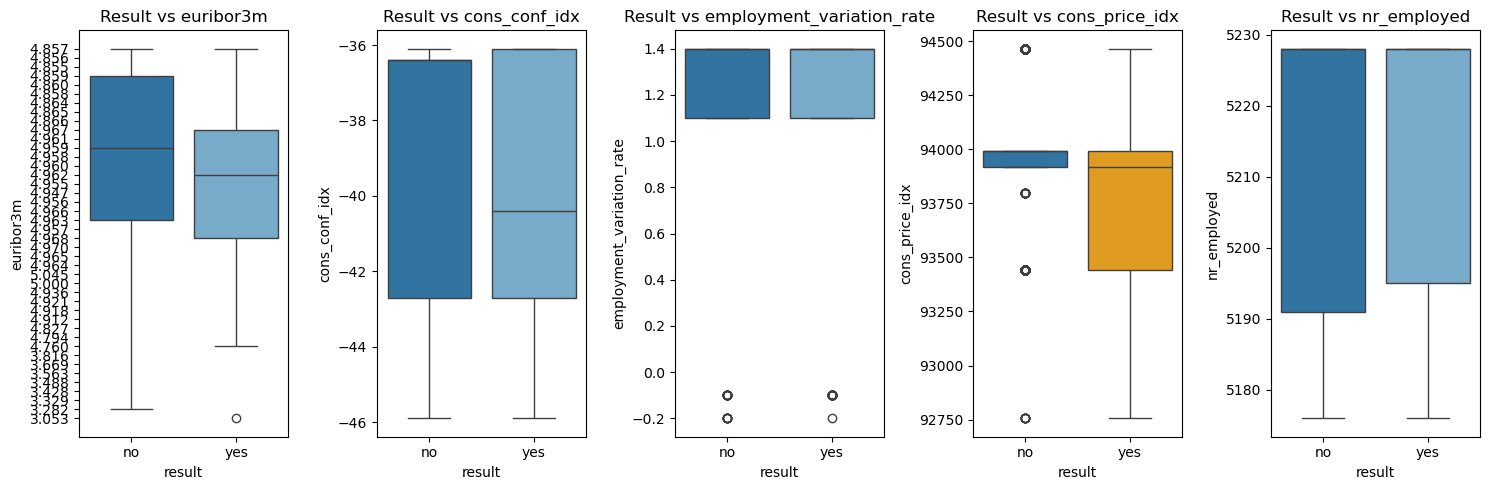

In [167]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

cols_numericas = ['euribor3m', 'cons_conf_idx', 'employment_variation_rate',
                  'cons_price_idx', 'nr_employed']

# Paletas de colores para cada gráfico (no, yes)
paletas = [
    ['#1f77b4', '#6baed6'],  # euribor3m - azules
    ['#1f77b4', '#6baed6'],   # cons_conf_idx - azul y naranja para yes
    ['#1f77b4', '#6baed6'],  # employment_variation_rate - azules
    ['#1f77b4', 'orange'],  # cons_price_idx - azules
    ['#1f77b4', '#6baed6']   # nr_employed - azules
]

for ax, col, paleta in zip(axes.flatten(), cols_numericas, paletas):
    sns.boxplot(data=df_clean_no_outliers, x='result', y=col, ax=ax, palette=paleta)
    ax.set_title(f'Result vs {col}')

plt.tight_layout()
plt.show()

La métrica que más nos llama la atención en este caso es la concentración de "no" en el 4º gráfico, en el de preocupación del consumo / precio. Lo que nos dice el gráfico es que si los índices están altos, es bastante más probable que nos digan que no. Sin embargo, vemos los "sí" más repartidos en valores menores de preocupación.

#### **Edad**


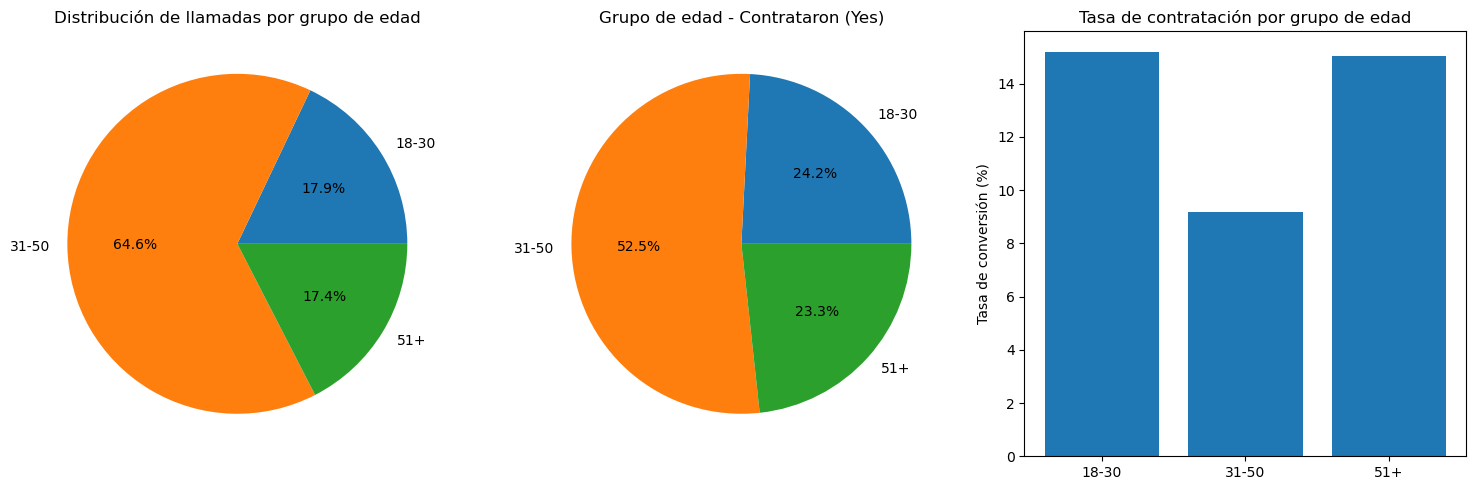

In [168]:
# Crear grupos de edad
df_clean['age_group'] = pd.cut(df_clean['age'], bins=[0, 30, 50, 100], 
                                labels=['18-30', '31-50', '51+'])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Pie distribución total de llamadas
age_counts = df_clean['age_group'].value_counts().sort_index()
axes[0].pie(age_counts, labels=age_counts.index, autopct='%1.1f%%')
axes[0].set_title('Distribución de llamadas por grupo de edad')

# Pie para los que contrataron (yes)
yes_data = df_clean[df_clean['result'] == 'yes']['age_group'].value_counts().sort_index()
axes[1].pie(yes_data, labels=yes_data.index, autopct='%1.1f%%')
axes[1].set_title('Grupo de edad - Contrataron (Yes)')

# Tasa de conversión por grupo de edad
conversion = df_clean.groupby('age_group')['result'].apply(lambda x: (x == 'yes').mean() * 100)
axes[2].bar(conversion.index, conversion.values)
axes[2].set_ylabel('Tasa de conversión (%)')
axes[2].set_title('Tasa de contratación por grupo de edad')

plt.tight_layout()
plt.show()

Tiene sentido la distribución de edad por el volumen de población en dichos segmentos.

Sí vemos un diferencia marcada del segmento más poblado, con algo más de un 9% de conversión, respecto al 15% de los otros dos, más de un 50% de diferencia.

Crucemos ahora los datos del índice de preocupación por los precios en los casos que no han contratado los precios. Dónde más veamos concentrados los valores, es donde más probable que nos digan que no. 

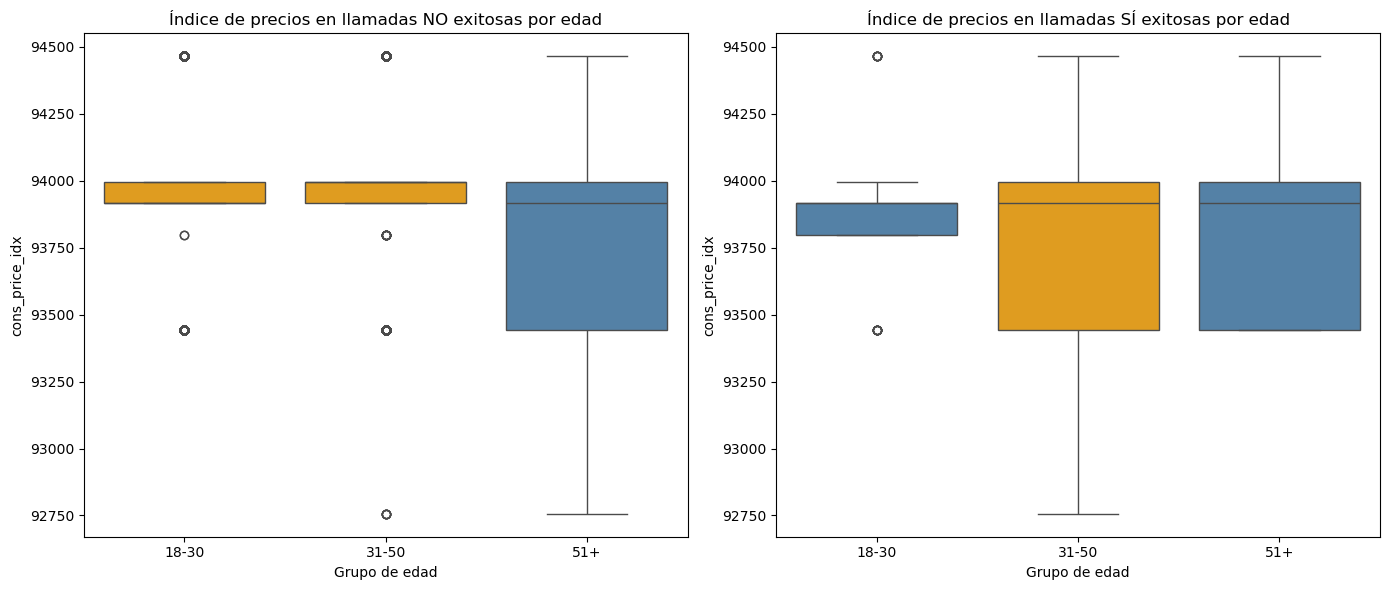

In [169]:
df_no = df_clean_no_outliers[df_clean_no_outliers['result'] == 'no']
df_yes = df_clean_no_outliers[df_clean_no_outliers['result'] == 'yes']

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Boxplot de los NO
colors_no = ['orange', 'orange', 'steelblue']  # 18-30, 31-50, 51+
sns.boxplot(data=df_no, x='age_group', y='cons_price_idx', palette=colors_no, ax=axes[0])
axes[0].set_title('Índice de precios en llamadas NO exitosas por edad')
axes[0].set_ylabel('cons_price_idx')
axes[0].set_xlabel('Grupo de edad')

# Boxplot de los YES
colors_yes = ['steelblue', 'orange', 'steelblue']
sns.boxplot(data=df_yes, x='age_group', y='cons_price_idx', palette=colors_yes, ax=axes[1])
axes[1].set_title('Índice de precios en llamadas SÍ exitosas por edad')
axes[1].set_ylabel('cons_price_idx')
axes[1].set_xlabel('Grupo de edad')

plt.tight_layout()
plt.show()

Todos los rechazos de la franja de 18 a 50 años se han concentrado en cuando el índice de preocupación por los precios era alto.

Sin embargo, en la franja de 31-50 vemos que las vecen que sí se suscriben al depósito se extienden datos incluso hasta el 92,75, cuando la preocupación está más baja.

Esto nos indica que este rango de edad **es más probable que se suscriba si llamamos cuando la preocupación por la inflación es más baja**.

#### **Trabajo**

En cuanto al trabajo, hemos querido comparar varias variables las llamadas que se han acabado suscribiendo al depósito para ver qué patrones vemos.

- **Tasa de conversión:** en el eje de las Y, cuanto más arriba se sitúe el punto, más porcentaje de conversión ha tenido el segmento.
- **% de volumen**: en el eje de las X, cuanto más a la derecha, más porcentaje de los usuarios suscritos supone.
- **Conversiones totales**: distribución de las conversiones totales en valores absolutos.

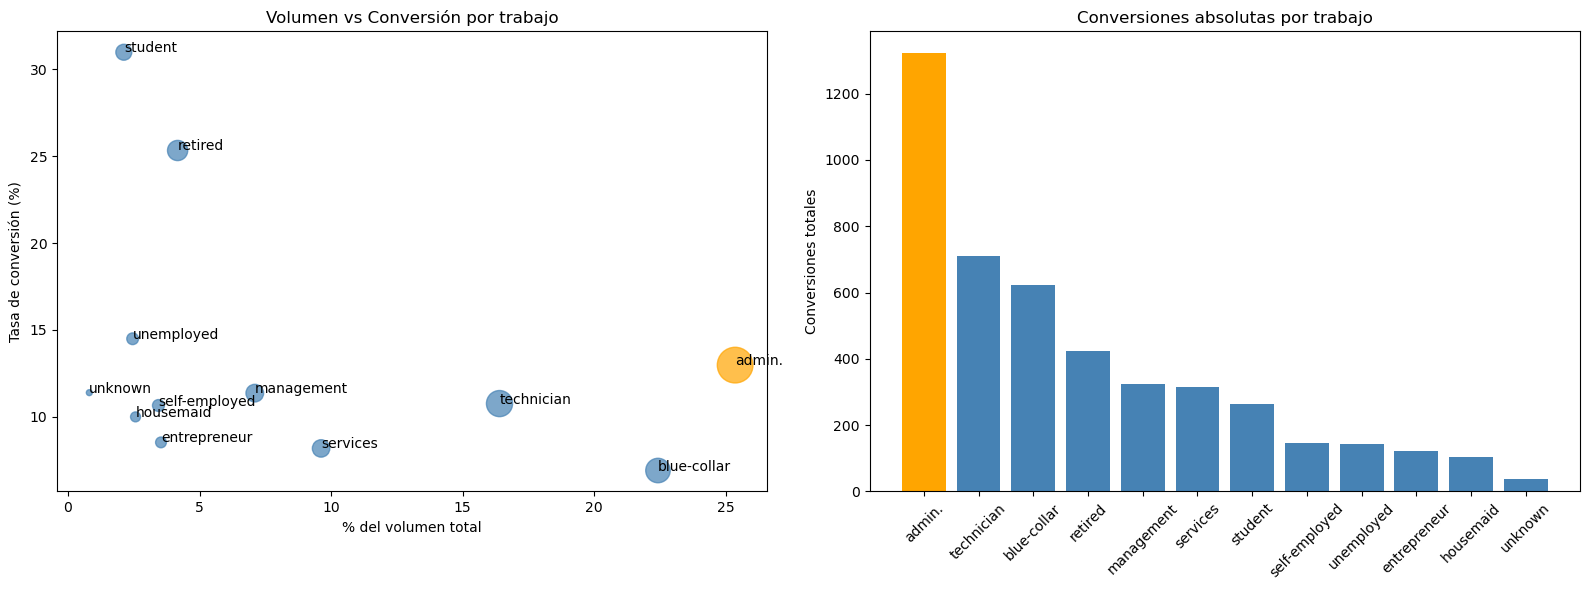

In [170]:
# Calcular métricas por job
stats_job = df_clean.groupby('job').agg(
    volumen=('result', 'count'),
    conversiones=('result', lambda x: (x == 'yes').sum()),
    tasa_conversion=('result', lambda x: (x == 'yes').mean() * 100)
).reset_index()

# Calcular porcentaje del volumen total
stats_job['pct_volumen'] = stats_job['volumen'] / stats_job['volumen'].sum() * 100

# Índice de eficiencia: conversiones absolutas (volumen * tasa)
stats_job['eficiencia'] = stats_job['conversiones']

# Ordenar por eficiencia
stats_job = stats_job.sort_values('eficiencia', ascending=False)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Scatter volumen vs tasa de conversión
colors = ['orange' if job == 'admin.' else 'steelblue' for job in stats_job['job']]
axes[0].scatter(stats_job['pct_volumen'], stats_job['tasa_conversion'], 
                s=stats_job['conversiones']/2, c=colors, alpha=0.7)
for i, row in stats_job.iterrows():
    axes[0].annotate(row['job'], (row['pct_volumen'], row['tasa_conversion']))
axes[0].set_xlabel('% del volumen total')
axes[0].set_ylabel('Tasa de conversión (%)')
axes[0].set_title('Volumen vs Conversión por trabajo')

# Gráfico 2: Conversiones absolutas (lo que realmente importa)
colors_bar = ['orange' if job == 'admin.' else 'steelblue' for job in stats_job['job']]
axes[1].bar(stats_job['job'], stats_job['conversiones'], color=colors_bar)
axes[1].set_ylabel('Conversiones totales')
axes[1].set_title('Conversiones absolutas por trabajo')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Encontramos en los trabajos administrativos un "sweet spot" en la conversión y en un volumen relevante en el caso de querer replicar el éxito en campañas venideras.


#### **Estado civil**

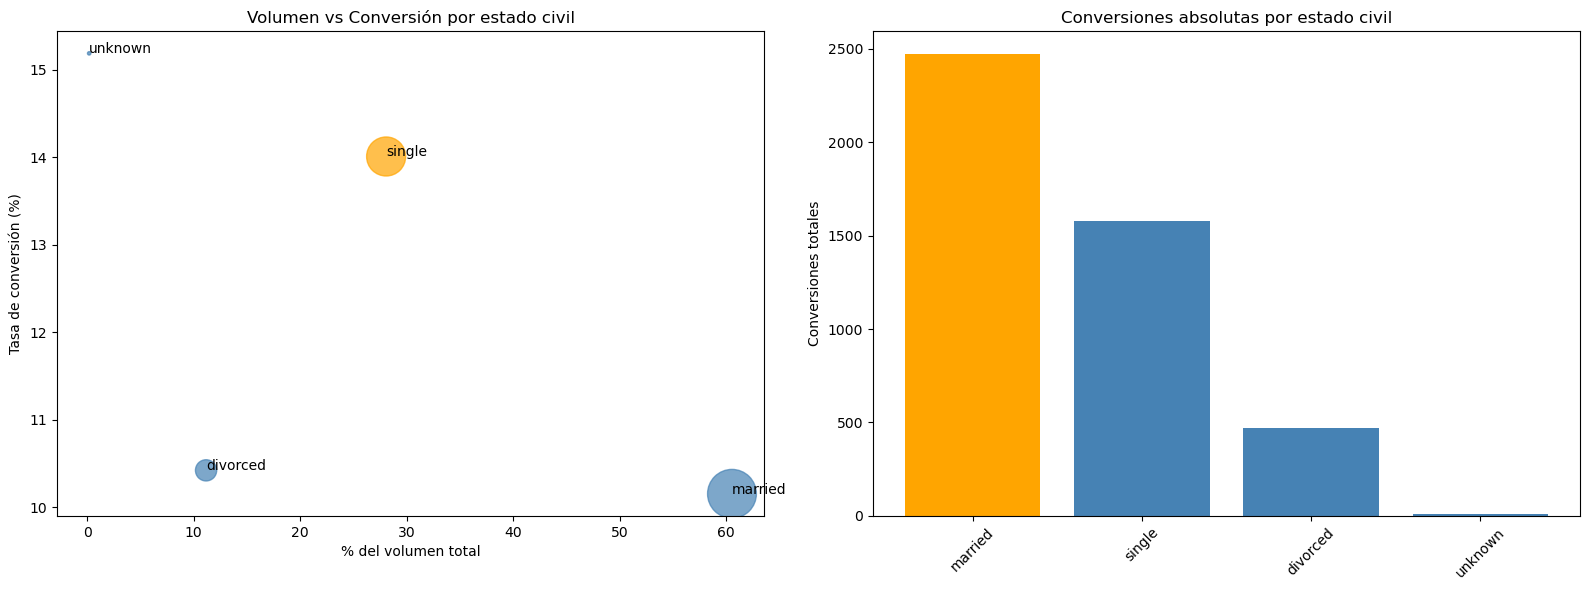

In [171]:
# Calcular métricas por marital
stats_marital = df_clean.groupby('marital').agg(
    volumen=('result', 'count'),
    conversiones=('result', lambda x: (x == 'yes').sum()),
    tasa_conversion=('result', lambda x: (x == 'yes').mean() * 100)
).reset_index()

# Calcular porcentaje del volumen total
stats_marital['pct_volumen'] = stats_marital['volumen'] / stats_marital['volumen'].sum() * 100

# Índice de eficiencia: conversiones absolutas (volumen * tasa)
stats_marital['eficiencia'] = stats_marital['conversiones']

# Ordenar por eficiencia
stats_marital = stats_marital.sort_values('eficiencia', ascending=False)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Scatter volumen vs tasa de conversión
colors = ['orange' if marital == 'single' else 'steelblue' for marital in stats_marital['marital']]
axes[0].scatter(stats_marital['pct_volumen'], stats_marital['tasa_conversion'], 
                s=stats_marital['conversiones']/2, c=colors, alpha=0.7)
for i, row in stats_marital.iterrows():
    axes[0].annotate(row['marital'], (row['pct_volumen'], row['tasa_conversion']))
axes[0].set_xlabel('% del volumen total')
axes[0].set_ylabel('Tasa de conversión (%)')
axes[0].set_title('Volumen vs Conversión por estado civil')

# Gráfico 2: Conversiones absolutas (lo que realmente importa)
colors_bar = ['orange' if marital == 'married' else 'steelblue' for marital in stats_marital['marital']]
axes[1].bar(stats_marital['marital'], stats_marital['conversiones'], color=colors_bar)
axes[1].set_ylabel('Conversiones totales')
axes[1].set_title('Conversiones absolutas por estado civil')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Se compensa el volumen de los casados con el buen CR% de los solteros, por lo que no vemos un ganador claro.

#### **Educación**

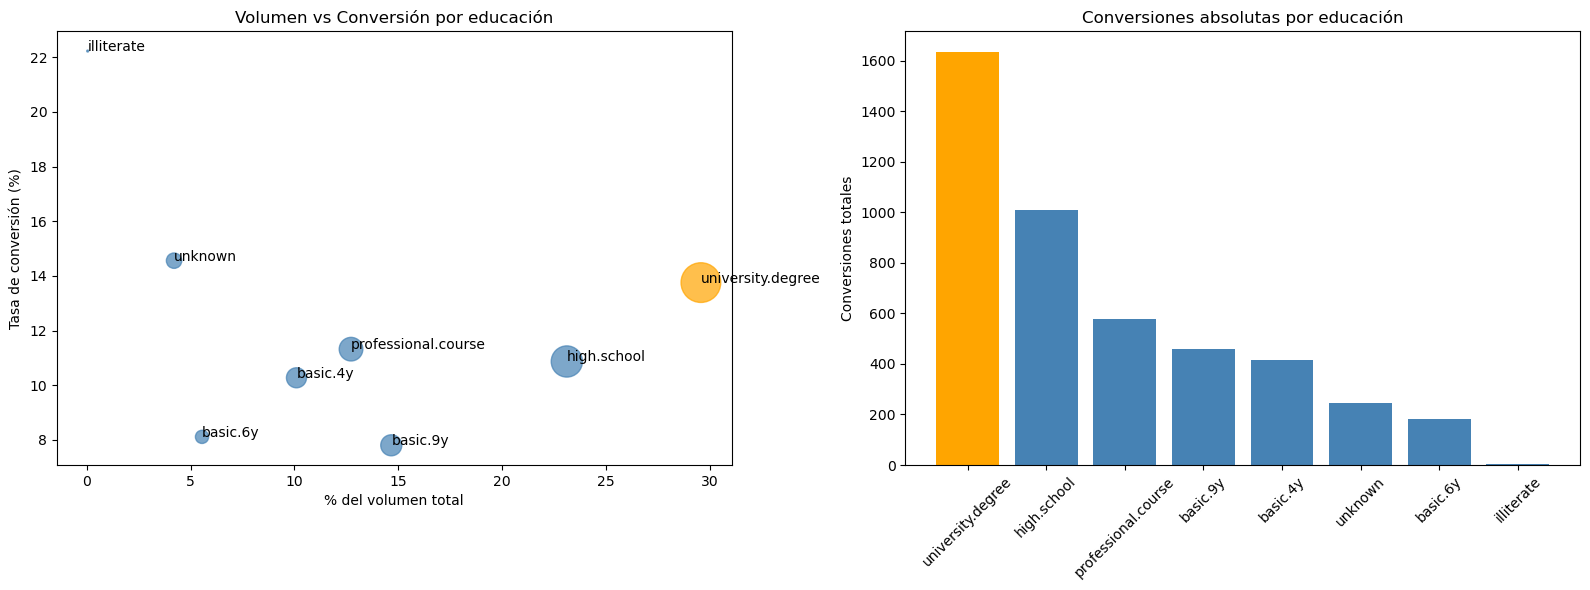

In [172]:
# Calcular métricas por education
stats_education = df_clean.groupby('education').agg(
    volumen=('result', 'count'),
    conversiones=('result', lambda x: (x == 'yes').sum()),
    tasa_conversion=('result', lambda x: (x == 'yes').mean() * 100)
).reset_index()

# Calcular porcentaje del volumen total
stats_education['pct_volumen'] = stats_education['volumen'] / stats_education['volumen'].sum() * 100

# Índice de eficiencia: conversiones absolutas (volumen * tasa)
stats_education['eficiencia'] = stats_education['conversiones']

# Ordenar por eficiencia
stats_education = stats_education.sort_values('eficiencia', ascending=False)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Scatter volumen vs tasa de conversión
colors = ['orange' if edu == 'university.degree' else 'steelblue' for edu in stats_education['education']]
axes[0].scatter(stats_education['pct_volumen'], stats_education['tasa_conversion'], 
                s=stats_education['conversiones']/2, c=colors, alpha=0.7)
for i, row in stats_education.iterrows():
    axes[0].annotate(row['education'], (row['pct_volumen'], row['tasa_conversion']))
axes[0].set_xlabel('% del volumen total')
axes[0].set_ylabel('Tasa de conversión (%)')
axes[0].set_title('Volumen vs Conversión por educación')

# Gráfico 2: Conversiones absolutas (lo que realmente importa)
colors_bar = ['orange' if edu == 'university.degree' else 'steelblue' for edu in stats_education['education']]
axes[1].bar(stats_education['education'], stats_education['conversiones'], color=colors_bar)
axes[1].set_ylabel('Conversiones totales')
axes[1].set_title('Conversiones absolutas por educación')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Vemos que aquí sí hay un claro ganador, donde tanto el mayor volumen de suscripciones al depósito como el mejor ratio de conversión se atribuyen al segmento de población que tiene al menos un grado universitario.

#### **Hipoteca**

Analizamos si la posesión de una hipoteca influye en la decisión de contratar un plazo o no.

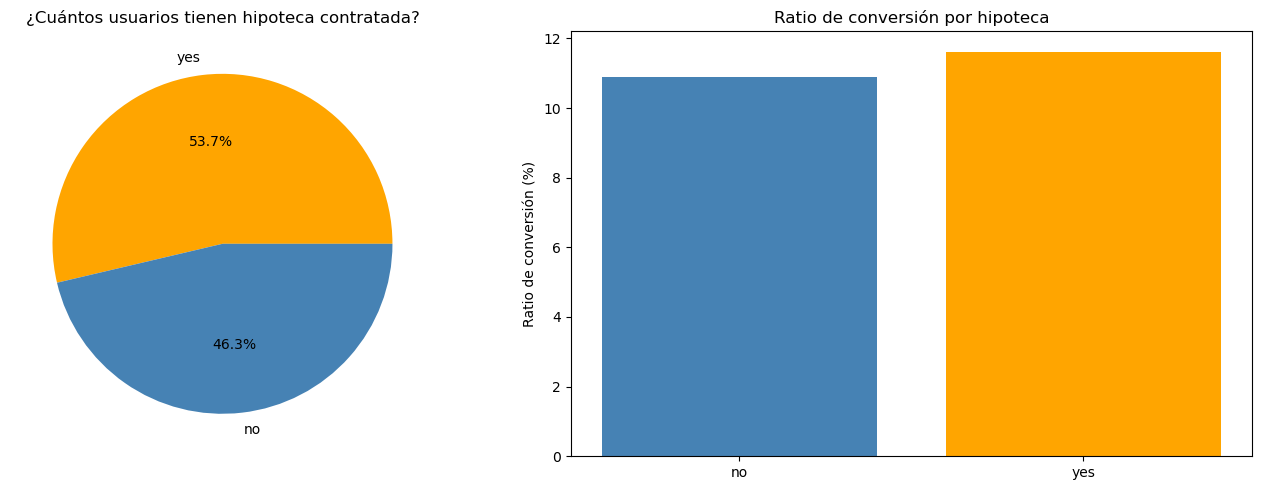

In [173]:
# Filtrar sin unknown
df_mortgage = df_clean

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart de distribución de hipoteca
mortgage_counts = df_mortgage['mortgage'].value_counts()
colors_pie = ['orange' if i == mortgage_counts.idxmax() else 'steelblue' for i in mortgage_counts.index]
axes[0].pie(mortgage_counts, labels=mortgage_counts.index, autopct='%1.1f%%', colors=colors_pie)
axes[0].set_title('¿Cuántos usuarios tienen hipoteca contratada?')

# Tasa de conversión por hipoteca
conversion = df_mortgage.groupby('mortgage')['result'].apply(lambda x: (x == 'yes').mean() * 100)
colors_conv = ['orange' if v == conversion.max() else 'steelblue' for v in conversion.values]
axes[1].bar(conversion.index, conversion.values, color=colors_conv)
axes[1].set_title('Ratio de conversión por hipoteca')
axes[1].set_ylabel('Ratio de conversión (%)')

plt.tight_layout()
plt.show()

Concluimos que el hecho de tener una hipoteca no ha influido en la decisión de contratar un depósito. Se ha llamado en partes relativamente iguales a clientes que tenían hipoteca o no. 

El ratio de conversión, de todas maneras, es bastante parecido.

#### **Préstamo**

Analizamos a continuación datos sobre los clientes dependiendo de si han pedido o no un préstamo.

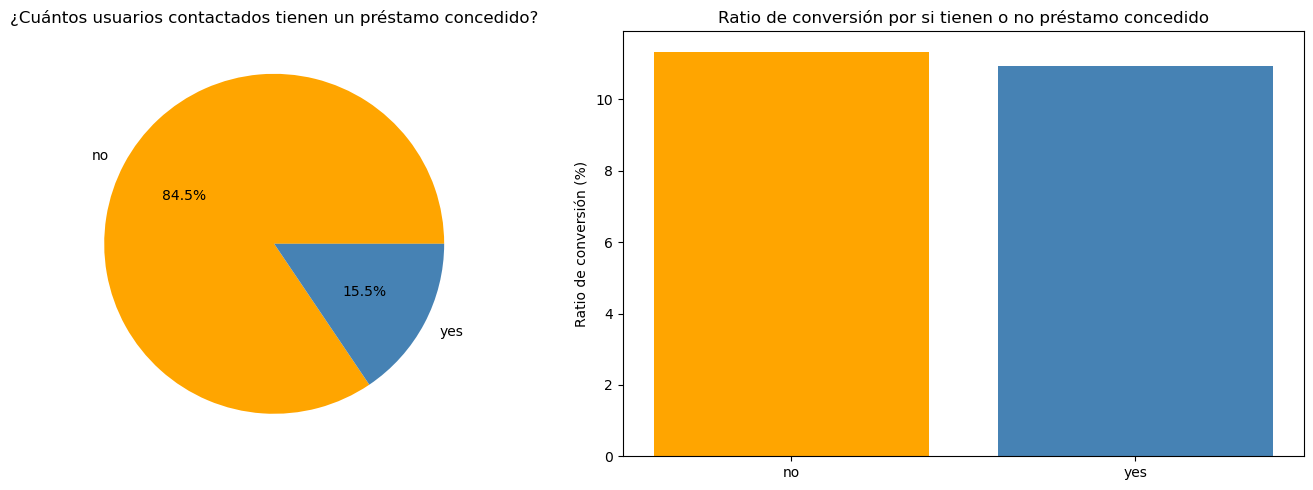

In [174]:
# Filtrar sin unknown
df_loan = df_clean[df_clean['loan'] != 'unknown']

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart de distribución de préstamo
loan_counts = df_loan['loan'].value_counts()
colors_pie = ['orange' if i == loan_counts.idxmax() else 'steelblue' for i in loan_counts.index]
axes[0].pie(loan_counts, labels=loan_counts.index, autopct='%1.1f%%', colors=colors_pie)
axes[0].set_title('¿Cuántos usuarios contactados tienen un préstamo concedido?')

# Tasa de conversión por préstamo
conversion = df_loan.groupby('loan')['result'].apply(lambda x: (x == 'yes').mean() * 100)
colors_conv = ['orange' if v == conversion.max() else 'steelblue' for v in conversion.values]
axes[1].bar(conversion.index, conversion.values, color=colors_conv)
axes[1].set_title('Ratio de conversión por si tienen o no préstamo concedido')
axes[1].set_ylabel('Ratio de conversión (%)')

plt.tight_layout()
plt.show()

Igual que en el caso anterior, no es un indicador relevante que a los hora de contratar o no un depósito.

#### **Morosidad**

Por último, analizaremos si el hecho de tener impago de crédito influye la contratación o no de un crédito.

Aquí hemos decidido incluir los unknown en los gráficos por dos razones:

1. Hay un 0% de morosos, por lo que nos parece correcto añadir los unknown para que el gráfico sea posible.
2. Es una métrica polémica que indica directamente si el contactado tiene problemas para afrontar pagos. Ante la duda, nos parece interesante incluir dichos valores "unknown".

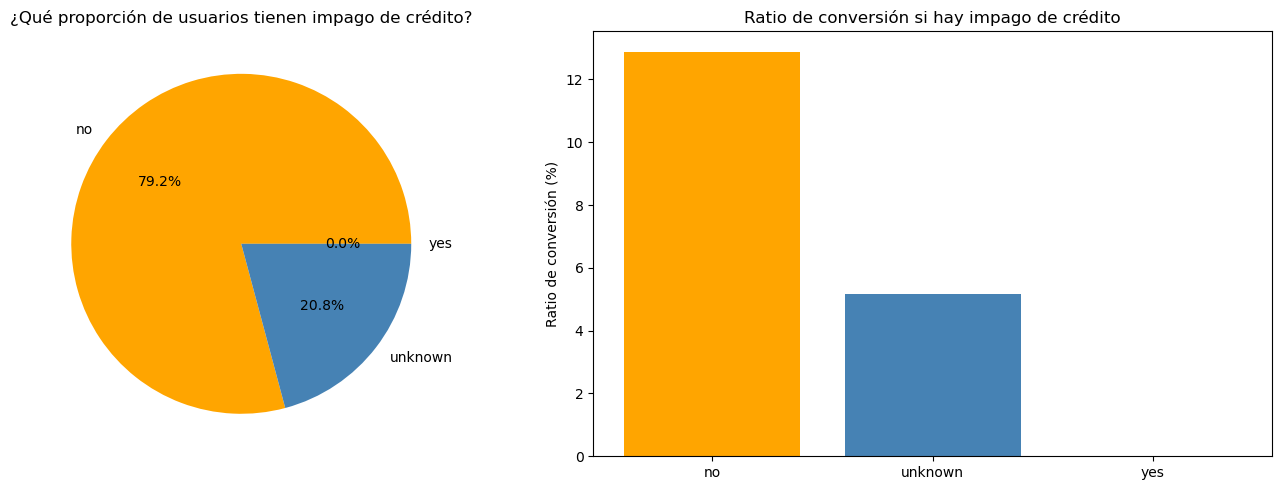

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart de distribución de credit_default
credit_counts = df_clean['credit_default'].value_counts()
colors_pie = ['orange' if i == credit_counts.idxmax() else 'steelblue' for i in credit_counts.index]
axes[0].pie(credit_counts, labels=credit_counts.index, autopct='%1.1f%%', colors=colors_pie)
axes[0].set_title('¿Qué proporción de usuarios tienen impago de crédito?')

# Tasa de conversión por credit_default
conversion = df_clean.groupby('credit_default')['result'].apply(lambda x: (x == 'yes').mean() * 100)
colors_conv = ['orange' if v == conversion.max() else 'steelblue' for v in conversion.values]
axes[1].bar(conversion.index, conversion.values, color=colors_conv)
axes[1].set_title('Ratio de conversión si hay impago de crédito')
axes[1].set_ylabel('Ratio de conversión (%)')

plt.tight_layout()
plt.show()

El 80% de los contactados no tiene deudas, mientras que el 20% restante se desconoce.

De todas formas, es curioso que el ratio de conversión de las llamadas con usuarios que NO tienen deudas (13%) sea más del doble que aquellos que se desconoce (5%), lo que indica que es probable que haya una cantidad considerable de morosos que o no se les permite contratar el depósito, o bien, no se lo quieren/pueden permitir, u otro motivo desconocido.

## **1.5. Evaluación del impacto de los detalles de la campaña (número de contactos, mes, día de la semana) en el resultado de la campaña.**

In [176]:
df_clean.columns

Index(['age', 'job', 'marital', 'education', 'credit_default', 'mortgage',
       'loan', 'device', 'month', 'day_of_week', 'duration',
       'number_of_contacts', 'days_last_contact', 'number_previous_contacts',
       'poutcome', 'employment_variation_rate', 'cons_price_idx',
       'cons_conf_idx', 'euribor3m', 'nr_employed', 'result', 'age_group'],
      dtype='object')

En  este apartado analizaremos los detalles y características propias de la campaña y su relación con el resultado de la misma, es decir, si el usuario contactado ha contratado o no el depósito.

Analizaremos los siguientes campos:

- 'device'
- 'month'
- 'day_of_week'
- 'duration'
- 'number_of_contacts'
- 'days_last_contact'
- 'number_previous_contacts',
- 'poutcome'

#### **Device**

#### **Month**

#### **Día de la semana**

#### **Duración de la llamada**

- **Duración de la llamada:** el rango intercuartilico se de las personas que han contratado el plazo se sitúa entre 7 y 10 minutos.

Esto nos indica rápidamente:

- Las llamadas más largas indican una mayor probabilidad a suscribirse al depósito.


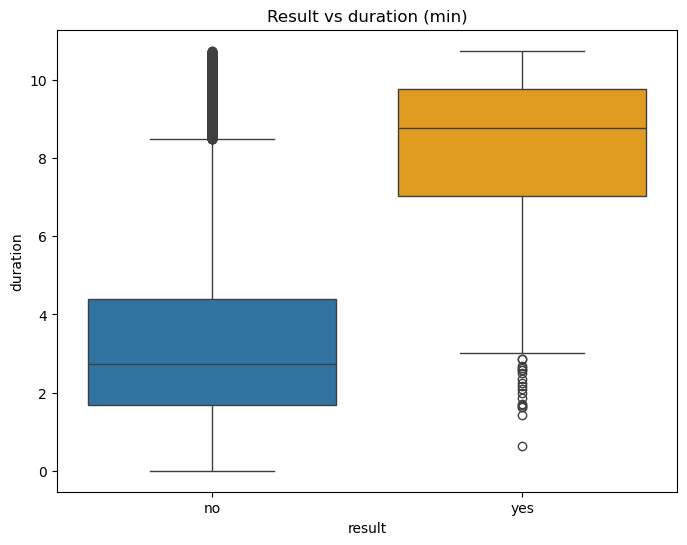

In [192]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_clean_no_outliers, x='result', y='duration', palette=['#1f77b4', 'orange'])
plt.title('Result vs duration (min)')
plt.show()

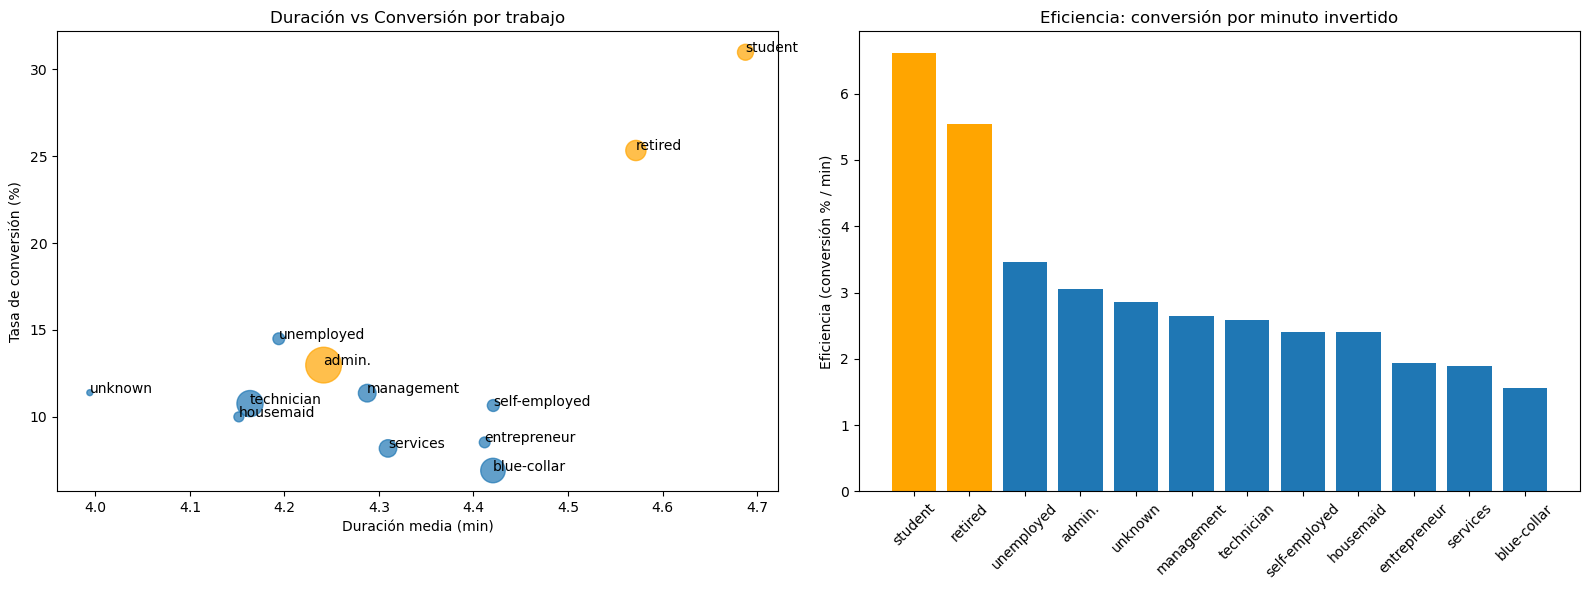

In [178]:
# Calcular métricas por job
stats_job = df_clean.groupby('job').agg(
    volumen=('result', 'count'),
    conversiones=('result', lambda x: (x == 'yes').sum()),
    tasa_conversion=('result', lambda x: (x == 'yes').mean() * 100),
    duracion_media=('duration', 'mean')
).reset_index()

# Índice de eficiencia: conversiones por minuto invertido
stats_job['eficiencia_tiempo'] = stats_job['tasa_conversion'] / stats_job['duracion_media']

# Ordenar por eficiencia
stats_job = stats_job.sort_values('eficiencia_tiempo', ascending=False)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Scatter duración vs tasa de conversión
destacados = ['admin.', 'student', 'retired']
colors_scatter = ['orange' if job in destacados else '#1f77b4' for job in stats_job['job']]
axes[0].scatter(stats_job['duracion_media'], stats_job['tasa_conversion'], 
                s=stats_job['conversiones']/2, c=colors_scatter, alpha=0.7)
for i, row in stats_job.iterrows():
    axes[0].annotate(row['job'], (row['duracion_media'], row['tasa_conversion']))
axes[0].set_xlabel('Duración media (min)')
axes[0].set_ylabel('Tasa de conversión (%)')
axes[0].set_title('Duración vs Conversión por trabajo')

# Gráfico 2: Eficiencia (conversión / tiempo)
stats_job_sorted = stats_job.sort_values('eficiencia_tiempo', ascending=False)
top_2 = stats_job_sorted['job'].head(2).tolist()
colors_bar = ['orange' if job in top_2 else '#1f77b4' for job in stats_job_sorted['job']]
axes[1].bar(stats_job_sorted['job'], stats_job_sorted['eficiencia_tiempo'], color=colors_bar)
axes[1].set_ylabel('Eficiencia (conversión % / min)')
axes[1].set_title('Eficiencia: conversión por minuto invertido')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

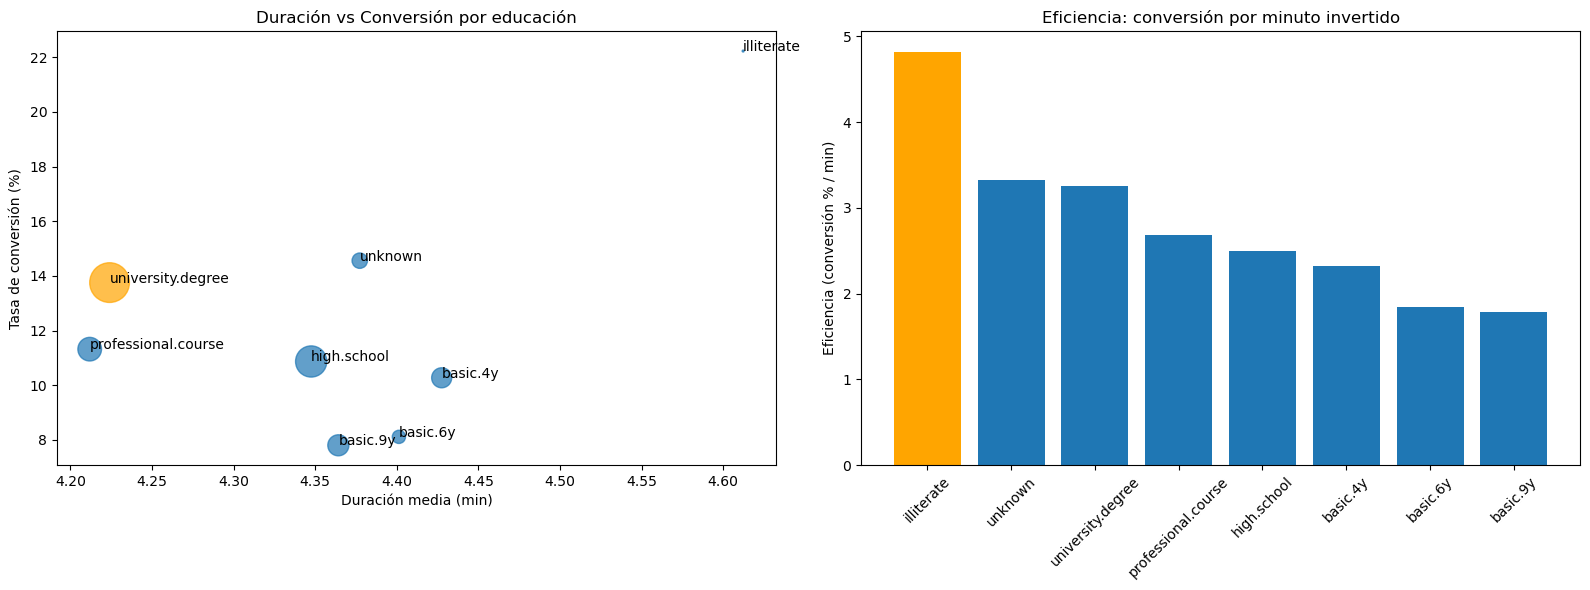

In [179]:
# Calcular métricas por education
stats_education = df_clean.groupby('education').agg(
    volumen=('result', 'count'),
    conversiones=('result', lambda x: (x == 'yes').sum()),
    tasa_conversion=('result', lambda x: (x == 'yes').mean() * 100),
    duracion_media=('duration', 'mean')
).reset_index()

# Índice de eficiencia: conversiones por minuto invertido
stats_education['eficiencia_tiempo'] = stats_education['tasa_conversion'] / stats_education['duracion_media']

# Ordenar por eficiencia
stats_education = stats_education.sort_values('eficiencia_tiempo', ascending=False)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Scatter duración vs tasa de conversión
colors_scatter = ['orange' if edu == 'university.degree' else '#1f77b4' for edu in stats_education['education']]
axes[0].scatter(stats_education['duracion_media'], stats_education['tasa_conversion'], 
                s=stats_education['conversiones']/2, c=colors_scatter, alpha=0.7)
for i, row in stats_education.iterrows():
    axes[0].annotate(row['education'], (row['duracion_media'], row['tasa_conversion']))
axes[0].set_xlabel('Duración media (min)')
axes[0].set_ylabel('Tasa de conversión (%)')
axes[0].set_title('Duración vs Conversión por educación')

# Gráfico 2: Eficiencia (conversión / tiempo)
stats_education_sorted = stats_education.sort_values('eficiencia_tiempo', ascending=False)
colors_bar = ['orange' if edu == 'illiterate' else '#1f77b4' for edu in stats_education_sorted['education']]
axes[1].bar(stats_education_sorted['education'], stats_education_sorted['eficiencia_tiempo'], color=colors_bar)
axes[1].set_ylabel('Eficiencia (conversión % / min)')
axes[1].set_title('Eficiencia: conversión por minuto invertido')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

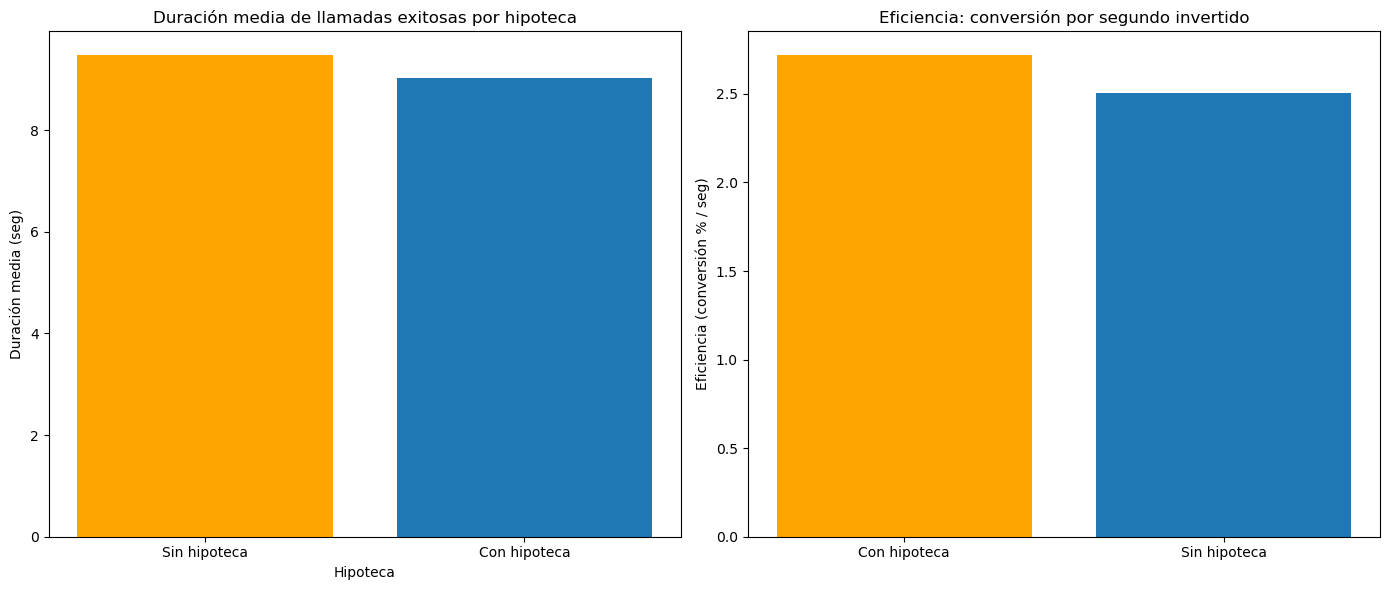

In [180]:
# Calcular métricas por mortgage (solo yes, sin unknown)
df_yes = df_clean[(df_clean['result'] == 'yes') & (df_clean['mortgage'] != 'unknown')]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Mapeo de labels
labels_mortgage = {'yes': 'Con hipoteca', 'no': 'Sin hipoteca'}

# Gráfico 1: Duración media
duration_mortgage = df_yes.groupby('mortgage')['duration'].mean().sort_values(ascending=False)
duration_mortgage.index = [labels_mortgage[m] for m in duration_mortgage.index]
colors_dur = ['orange' if m == duration_mortgage.idxmax() else '#1f77b4' for m in duration_mortgage.index]
axes[0].bar(duration_mortgage.index, duration_mortgage.values, color=colors_dur)
axes[0].set_title('Duración media de llamadas exitosas por hipoteca')
axes[0].set_ylabel('Duración media (seg)')
axes[0].set_xlabel('Hipoteca')

# Gráfico 2: Eficiencia (conversión / tiempo)
df_mortgage = df_clean[df_clean['mortgage'] != 'unknown']
stats_mortgage = df_mortgage.groupby('mortgage').agg(
    tasa_conversion=('result', lambda x: (x == 'yes').mean() * 100),
    duracion_media=('duration', 'mean')
).reset_index()
stats_mortgage['eficiencia_tiempo'] = stats_mortgage['tasa_conversion'] / stats_mortgage['duracion_media']
stats_mortgage = stats_mortgage.sort_values('eficiencia_tiempo', ascending=False)
stats_mortgage['mortgage_label'] = stats_mortgage['mortgage'].map(labels_mortgage)
colors_eff = ['orange' if m == stats_mortgage['mortgage_label'].iloc[0] else '#1f77b4' for m in stats_mortgage['mortgage_label']]
axes[1].bar(stats_mortgage['mortgage_label'], stats_mortgage['eficiencia_tiempo'], color=colors_eff)
axes[1].set_ylabel('Eficiencia (conversión % / seg)')
axes[1].set_title('Eficiencia: conversión por segundo invertido')

plt.tight_layout()
plt.show()

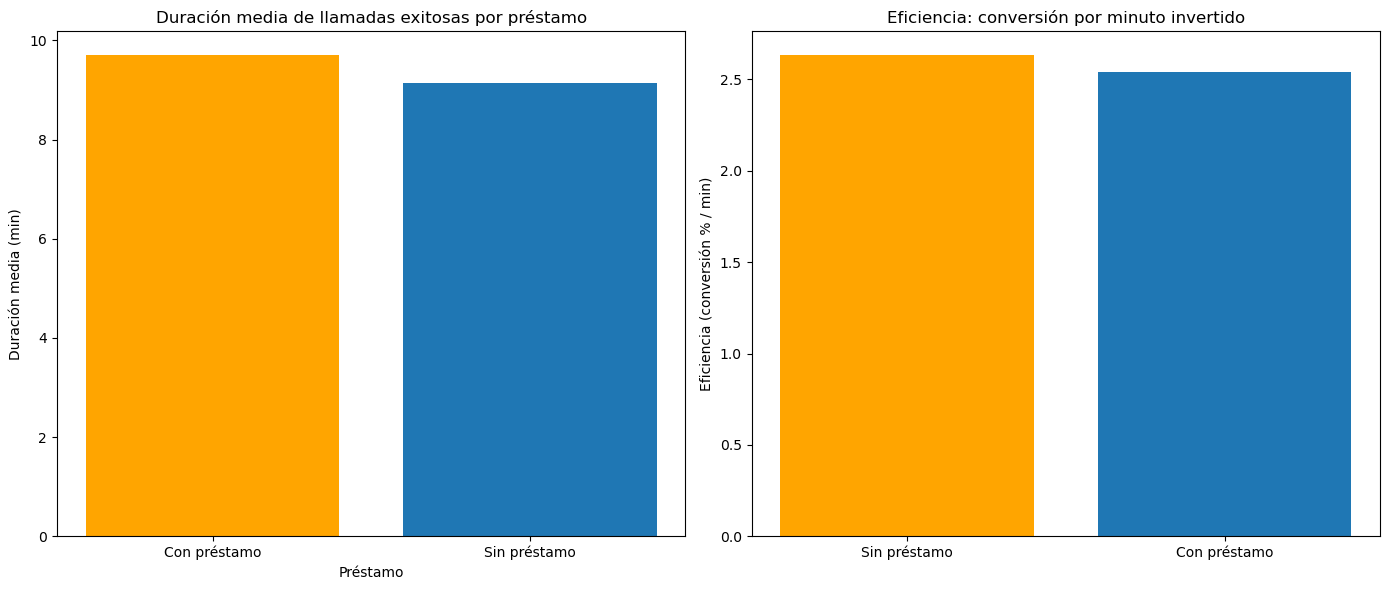

In [181]:
# Calcular métricas por loan (solo yes, sin unknown)
df_yes = df_clean[(df_clean['result'] == 'yes') & (df_clean['loan'] != 'unknown')]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Mapeo de labels
labels_loan = {'yes': 'Con préstamo', 'no': 'Sin préstamo'}

# Gráfico 1: Duración media
duration_loan = df_yes.groupby('loan')['duration'].mean().sort_values(ascending=False)
duration_loan.index = [labels_loan[l] for l in duration_loan.index]
colors_dur = ['orange' if l == duration_loan.idxmax() else '#1f77b4' for l in duration_loan.index]
axes[0].bar(duration_loan.index, duration_loan.values, color=colors_dur)
axes[0].set_title('Duración media de llamadas exitosas por préstamo')
axes[0].set_ylabel('Duración media (min)')
axes[0].set_xlabel('Préstamo')

# Gráfico 2: Eficiencia (conversión / tiempo)
df_loan = df_clean[df_clean['loan'] != 'unknown']
stats_loan = df_loan.groupby('loan').agg(
    tasa_conversion=('result', lambda x: (x == 'yes').mean() * 100),
    duracion_media=('duration', 'mean')
).reset_index()
stats_loan['eficiencia_tiempo'] = stats_loan['tasa_conversion'] / stats_loan['duracion_media']
stats_loan = stats_loan.sort_values('eficiencia_tiempo', ascending=False)
stats_loan['loan_label'] = stats_loan['loan'].map(labels_loan)
colors_eff = ['orange' if l == stats_loan['loan_label'].iloc[0] else '#1f77b4' for l in stats_loan['loan_label']]
axes[1].bar(stats_loan['loan_label'], stats_loan['eficiencia_tiempo'], color=colors_eff)
axes[1].set_ylabel('Eficiencia (conversión % / min)')
axes[1].set_title('Eficiencia: conversión por minuto invertido')

plt.tight_layout()
plt.show()

#### **Nº de contactos**

#### **Días desde el último contacto**

#### **Número de contactos previos**

#### **Resultado previo**

__________________________________________________________________________________________

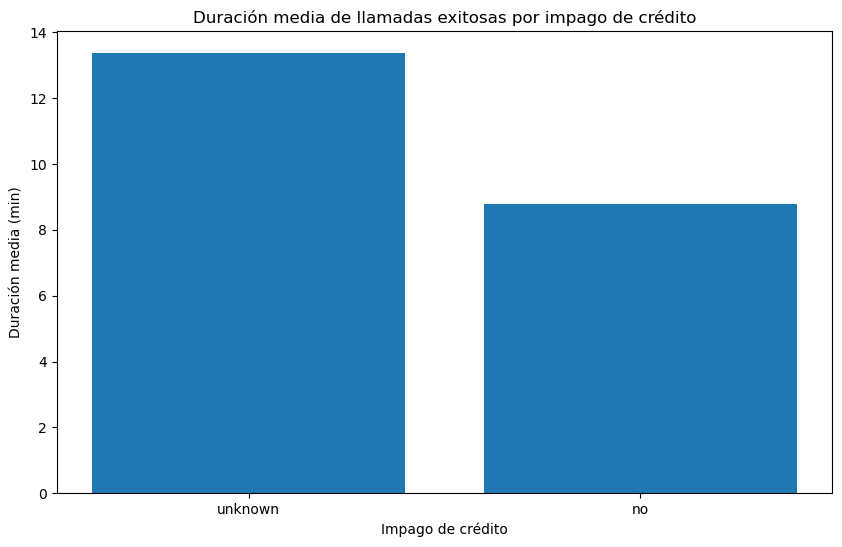

In [182]:
# Duración media por impago de crédito (solo yes)
df_yes = df_clean[df_clean['result'] == 'yes']

plt.figure(figsize=(10, 6))
duration_credit = df_yes.groupby('credit_default')['duration'].mean().sort_values(ascending=False)
plt.bar(duration_credit.index, duration_credit.values)
plt.title('Duración media de llamadas exitosas por impago de crédito')
plt.ylabel('Duración media (min)')
plt.xlabel('Impago de crédito')
plt.show()

**¿Cuál es la proporción de los usuarios que contrataron un depósito?**

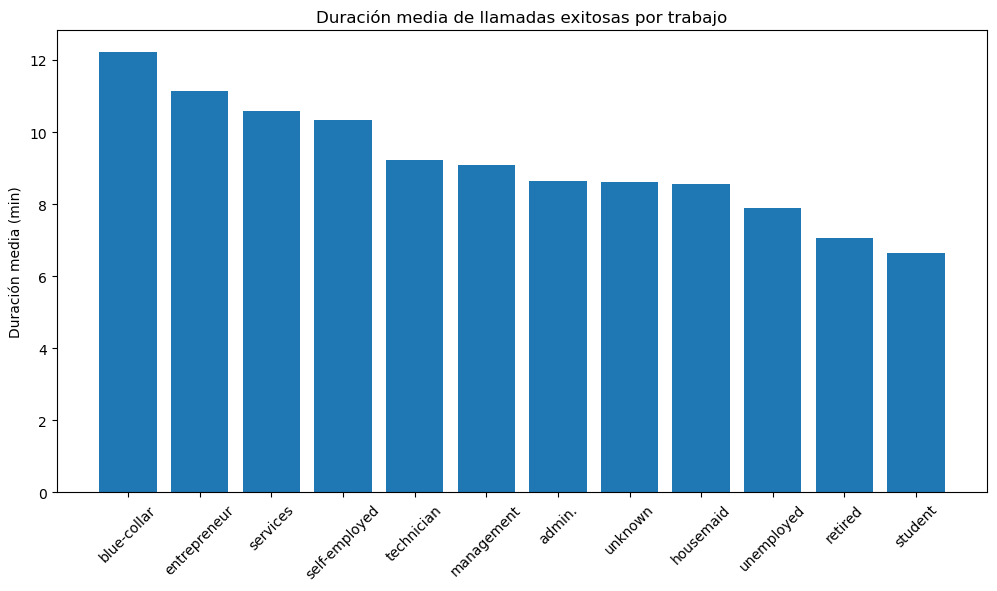

In [183]:
# Duración media por trabajo (solo yes)
df_yes = df_clean[df_clean['result'] == 'yes']

plt.figure(figsize=(12, 6))
duration_job = df_yes.groupby('job')['duration'].mean().sort_values(ascending=False)
plt.bar(duration_job.index, duration_job.values)
plt.title('Duración media de llamadas exitosas por trabajo')
plt.ylabel('Duración media (min)')
plt.xticks(rotation=45)
plt.show()

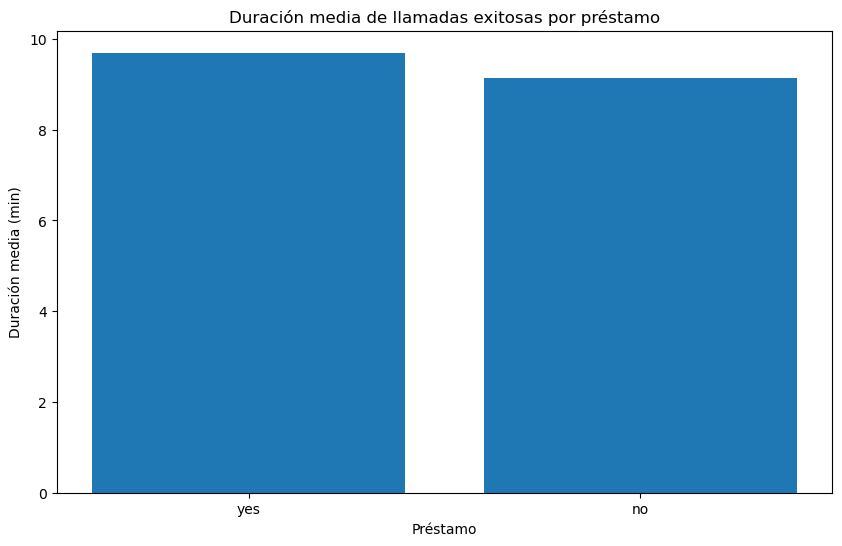

In [184]:
# Duración media por préstamo (solo yes)
df_yes = df_clean[df_clean['result'] == 'yes']

plt.figure(figsize=(10, 6))
duration_loan = df_yes.groupby('loan')['duration'].mean().sort_values(ascending=False)
plt.bar(duration_loan.index, duration_loan.values)
plt.title('Duración media de llamadas exitosas por préstamo')
plt.ylabel('Duración media (min)')
plt.xlabel('Préstamo')
plt.show()

In [185]:
df_yes_no = df_clean['result'].value_counts(normalize=True)*100

df_yes_no

result
no     88.722441
yes    11.277559
Name: proportion, dtype: float64

<Axes: ylabel='count'>

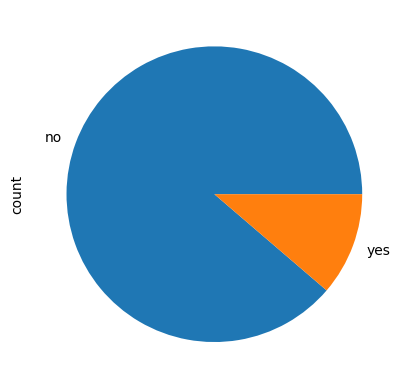

In [186]:
df_clean['result'].value_counts().plot.pie()

**¿Cuál es la distribución de las llamadas en meses?**

<Axes: xlabel='month', ylabel='count'>

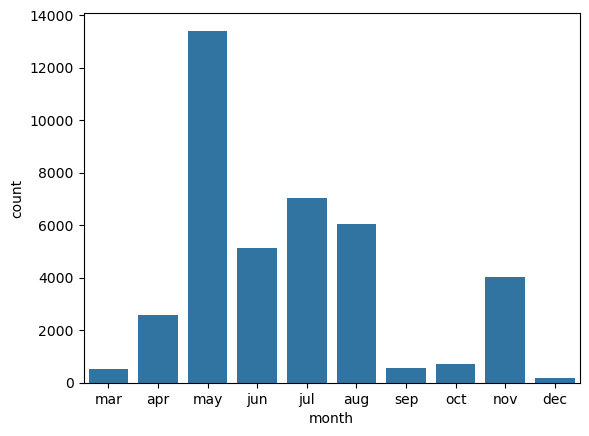

In [187]:
orden_meses = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

sns.countplot(data=df_clean, x='month', order=orden_meses)

**¿Cuántas veces se contacta al cliente? Distribución**

<Axes: xlabel='campaign', ylabel='Count'>

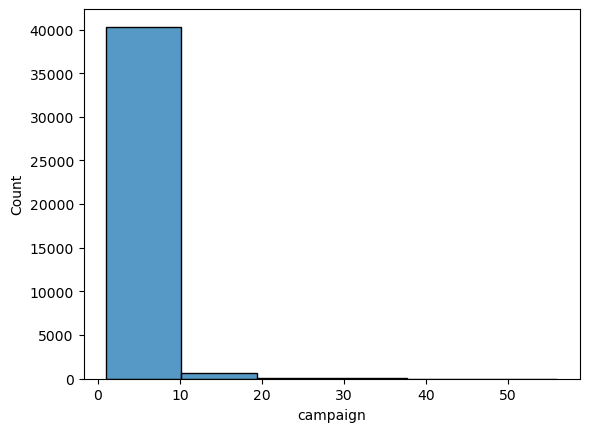

In [188]:
sns.histplot(df['campaign'], bins=6)

**¿Existe correlación entre la contratación del plazo y el euribor?**